# MNIST CNN Layer Visualization

到現在為止我們已經完成了用卷積神經網路來實現手寫數字的辨識，接下來我們想要看看在卷積神經網路中每一層它的辨識的效果如何，是不是會跟我們預想，或者跟理論上所說的 **越深的網路，效果越好**．

要完成這樣的工作，最好的方式就是使用降維加上視覺化方法，來幫助我們了解神經網路的表現．以下我先建立了一個三層卷積層加上兩層全連結層的神經網路，並使用 MNIST 資料集做訓練．並且把訓練好的模型參數儲存下來，以供接下來使用．

降維的方法則使用 `PCA` 以及 `TSNE` 兩種方法來進行比較：

In [1]:
%matplotlib inline
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
current_dir = os.getcwd()
sess = tf.InteractiveSession()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 三層卷積層加上兩層全連結層模型定義

In [2]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial, name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial, name)

def conv2d(X, W):
    return tf.nn.conv2d(X, W, strides = [1, 1, 1, 1], padding = 'SAME')

def max_pool_2x2(X):
    return tf.nn.max_pool(X, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

def add_layer(X, W, B):
    h_conv = tf.nn.relu(conv2d(X, W) + B)
    return max_pool_2x2(h_conv)

x = tf.placeholder(tf.float32, shape = [None, 784])
y_ = tf.placeholder(tf.float32, shape = [None, 10])
x_image = tf.reshape(x, [-1, 28, 28, 1])

layer1 = add_layer(x_image, weight_variable([5, 5, 1, 32], "w_conv1"), bias_variable([32], "b_conv1"))

layer2 = tf.nn.relu(conv2d(layer1, weight_variable([5, 5, 32, 48], "w_conv2")) + bias_variable([48], "b_conv2"))

layer3 = add_layer(layer2, weight_variable([5, 5, 48, 64], "w_conv3"), bias_variable([64], "b_conv3"))

W_fc1 = weight_variable([7 * 7 * 64, 1024], "w_fc1")
b_fc1 = bias_variable([1024], "b_fc1")
h_pool2_flat = tf.reshape(layer3, [-1, 7 * 7 * 64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
W_fc2 = weight_variable([1024, 10], "w_fc2")
b_fc2 = bias_variable([10], "b_fc2")
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver=tf.train.Saver()

saver.restore(sess, os.path.join(current_dir, "model/mnist_cnn_3_layer/model.ckpt"))


### 建立 pca 以及 tsne 降維法

In [3]:
def pca(X, n_components):
    pca = PCA(n_components = n_components)
    pca.fit(X)
    return pca.transform(X)

In [4]:
def tsne(X, n_components):
    model = TSNE(n_components=2, perplexity=40)
    return model.fit_transform(X)

### 建立畫圖函數

In [5]:
def plot_scatter(x, labels, title, txt = False):
    plt.title(title)
    ax = plt.subplot()
    ax.scatter(x[:,0], x[:,1], c = labels)
    txts = []
    if txt:
        for i in range(10):
            xtext, ytext = np.median(x[labels == i, :], axis=0)
            txt = ax.text(xtext, ytext, str(i), fontsize=24)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])
            txts.append(txt)
    plt.show()

In [8]:
test_size = 5000
test_data = mnist.test.images[0:test_size, :]
test_label = mnist.test.labels[0:test_size, :]
test_label_index = np.argmax(test_label, axis = 1)

## PCA

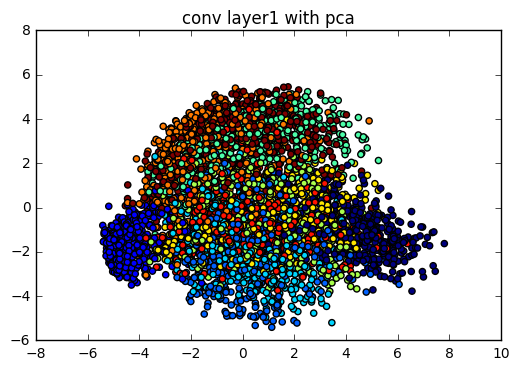

In [9]:
layer1_reshape = tf.reshape(layer1[:, :, :, :], [-1, 14 * 14 * 32])
test_layer1_pca = pca(layer1_reshape.eval(feed_dict = {x: test_data}), 2)
plot_scatter(test_layer1_pca, test_label_index, "conv layer1 with pca")

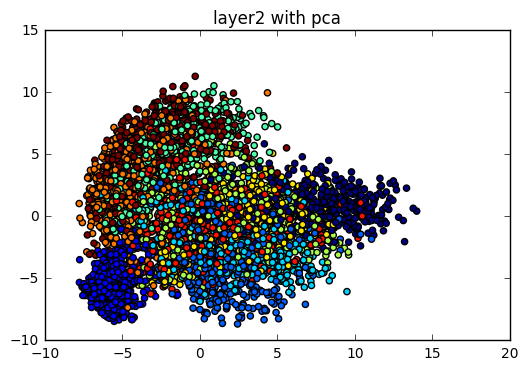

In [10]:
layer2_reshape = tf.reshape(layer2[:, :, :, :], [-1, 14 * 14 * 48])
test_layer2_pca = pca(layer2_reshape.eval(feed_dict = {x: test_data}), 2)
plot_scatter(test_layer2_pca, test_label_index, "layer2 with pca")

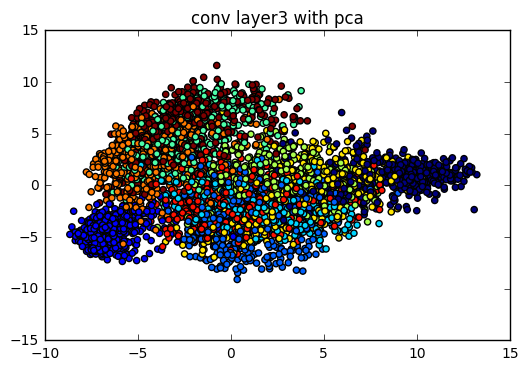

In [11]:
layer3_reshape = tf.reshape(layer3[:, :, :, :], [-1, 7 * 7 * 64])
test_layer3_pca = pca(layer3_reshape.eval(feed_dict = {x: test_data}), 2)
plot_scatter(test_layer3_pca, test_label_index, "conv layer3 with pca")

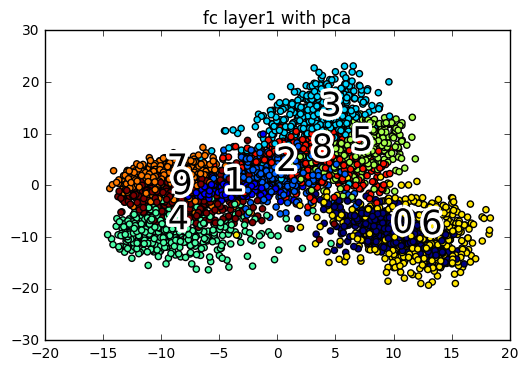

In [13]:
fc1_pca = pca(h_fc1.eval(feed_dict = {x: test_data}), 2)
plot_scatter(fc1_pca, test_label_index, "fc layer1 with pca", txt = True)

### 小結
我們可以看到 `PCA` 的方法並不是很理想，每一層的資料點都混雜在一起，只有在最後經過了全連結層後，看起來的結果好像比較好一點．而這個現象的原因是因為 `PCA` 是一個線性降維法，MNIST 在高維空間是一個非線性的分佈，而且 `PCA` 降維的時候會找 `variance` 最大的方向降維，使得點與點的距離可能被扭曲，導致視覺化的效果不太好．(關於 PCA 的特型可以參考以下的學習資源連結)

## TSNE
TSNE 的特性為在降維的時候，會保持點和數個點之間的遠近關係，不會因為降維後改變．假設在高維空間已經被分群了，那在低維會把這個群和群之間的分群關係保留下來．我們看以下的例子就會很清楚．

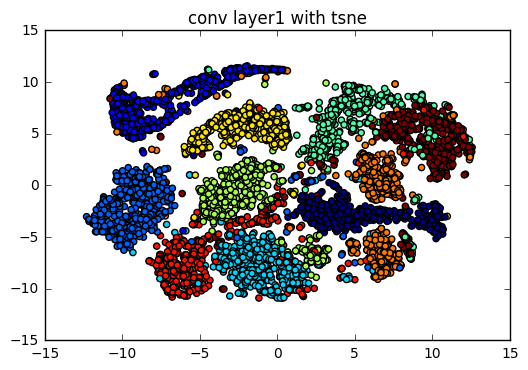

In [14]:
layer1_reshape = tf.reshape(layer1[:, :, :, :], [-1, 14 * 14 * 32])
layer1_pca = pca(layer1_reshape.eval(feed_dict ={ x: test_data}), 50)
layer1_tsne = tsne(layer1_pca, 2)
plot_scatter(layer1_tsne, test_label_index, "conv layer1 with tsne")

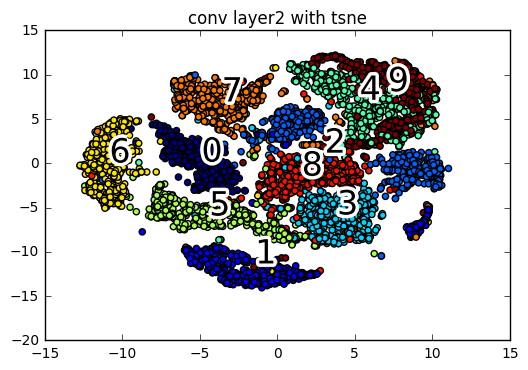

In [15]:
layer2_reshape = tf.reshape(layer2[:, :, :, :], [-1, 14 * 14 * 48])
layer2_pca = pca(layer2_reshape.eval(feed_dict ={ x: test_data}), 50)
layer2_tsne = tsne(layer2_pca, 2)
plot_scatter(layer2_tsne, test_label_index, "conv layer2 with tsne", txt = True)

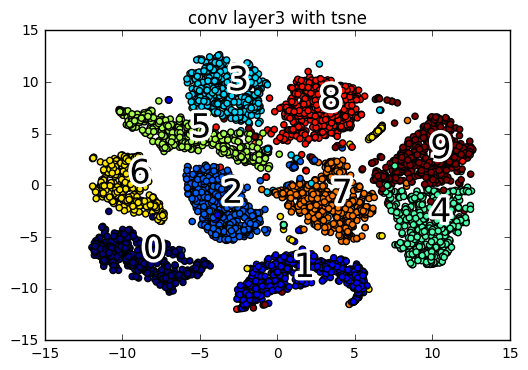

In [16]:
layer3_reshape = tf.reshape(layer3[:, :, :, :], [-1, 7 * 7 * 64])
layer3_pca = pca(layer3_reshape.eval(feed_dict = {x: test_data}), 50)
layer3_tsne = tsne(layer3_pca, 2)
plot_scatter(layer3_tsne, test_label_index, "conv layer3 with tsne", txt = True)

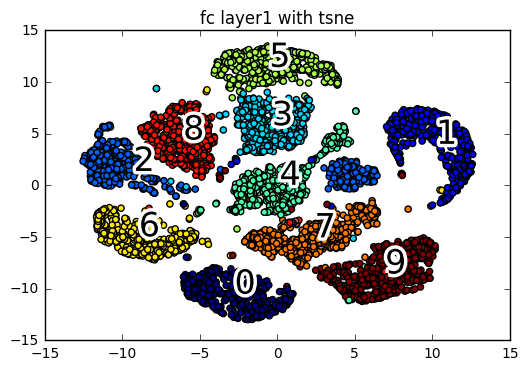

In [17]:
fc1_pca = pca(h_fc1.eval(feed_dict = {x: test_data}), 50)
fc1_tsne = tsne(fc1_pca, 2)
plot_scatter(fc1_tsne, test_label_index, "fc layer1 with tsne", txt = True)

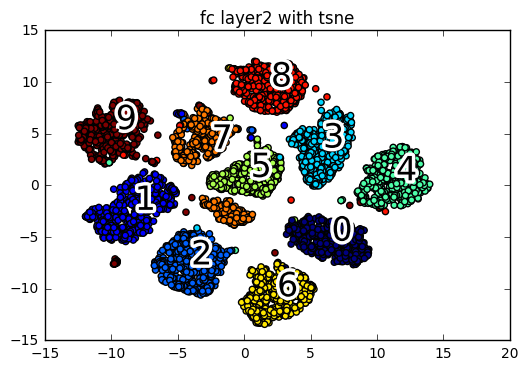

In [18]:
fc2_tsne = tsne(y_conv.eval(feed_dict = {x: test_data, keep_prob: 1.0}), 2)
plot_scatter(fc2_tsne, test_label_index, "fc layer2 with tsne", txt = True)

### 小結
我們可以看到隨著層數增加，分群的效果明顯地可以說是越來越好．值得注意的是一些點會出現在別的群裡，例如有一個 4 的點出現在 9 裡面，可見得它們可能因為手寫的時候太相似，機器就把它分類在一起．

## 今日心得
今天我們使用了 `PCA` 和 `TSNE` 兩個方法來做卷積神經網路分層視覺化的表現，可以看到神經網路越深的時候它的效果就越好．而關於 `PCA` 以及 `TSNE` 的數學部分，以下附上我學習的連結．

## 學習資源連結

- [Github t-SNE 教學](https://github.com/oreillymedia/t-SNE-tutorial)
- [台大李宏毅教授教學](https://www.youtube.com/watch?v=iwh5o_M4BNU)